<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

## 1. Background + Examples

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [2]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [3]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [4]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [5]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [6]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.18 seconds


/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/maxharvey/miniforge3/envs/dedalus3/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

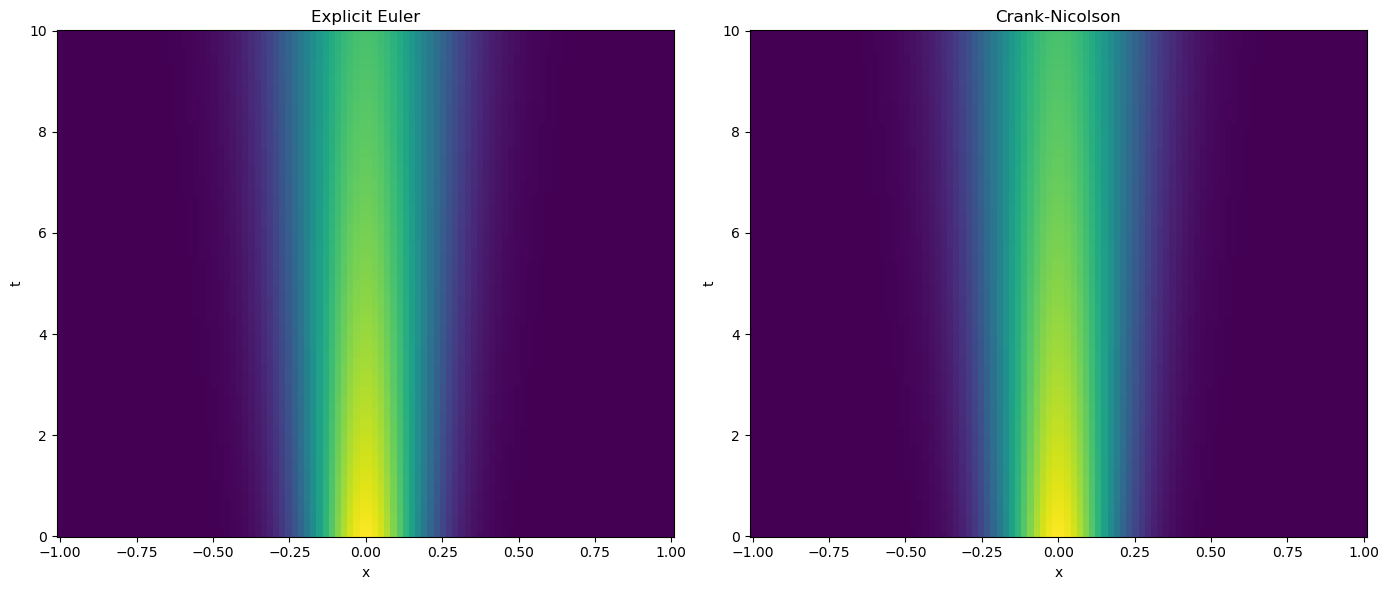

In [7]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability


<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

The system is stable when $$\kappa \frac{\Delta t}{(\Delta x)^2}<\frac{1}{2}$$



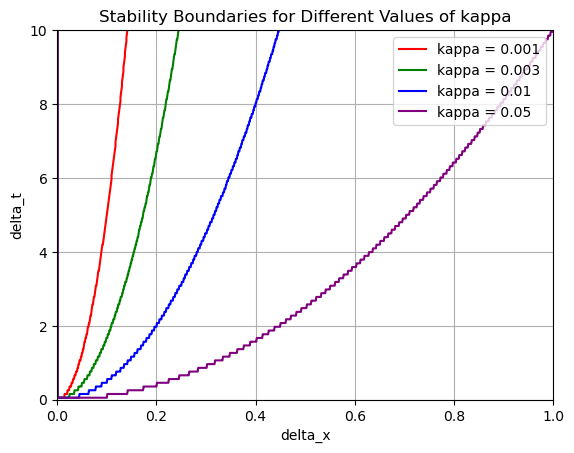

In [8]:
# Going to define some meshgrid of t and x values and then for different values of kappa we can plot different lines of stability


import numpy as np
import matplotlib.pyplot as plt

# Define the ranges
delta_x_values = np.linspace(0, 1, 1000)
delta_t_values = np.linspace(0, 10, 100)
kappa_values = [0.001, 0.003, 0.01, 0.05]

plt.figure()

# Define a list of colors (one for each kappa)
colors = ['r', 'g', 'b', 'purple']  # Specify colors for each kappa

# Loop over each kappa value
for i, kappa in enumerate(kappa_values):
    stability_matrix = np.zeros((len(delta_x_values), len(delta_t_values)))

    # Fill the stability matrix
    for j, delta_x in enumerate(delta_x_values):
        for k, delta_t in enumerate(delta_t_values):
            if delta_x != 0:  # Avoid division by zero for delta_x = 0
                stability_matrix[j, k] = kappa * delta_t / (delta_x)**2

    # Identify values below 0.5
    below_threshold = stability_matrix < 0.5

    # Plot the boundary using `plt.contour` with specified color
    contour = plt.contour(delta_x_values, delta_t_values, below_threshold.T, levels=[0.5], colors=colors[i])

    # Add a label for the line in the legend
    plt.plot([], [], color=colors[i], label=f'kappa = {kappa}')

# Add title and labels
plt.title('Stability Boundaries for Different Values of kappa')
plt.xlabel('delta_x')
plt.ylabel('delta_t')
plt.grid(True)

# Add a legend
plt.legend()

# Show the plot
plt.show()







Region of acceptance is under the graph

TODO: Write analysis of the graph and discussion

### 2.2 Accuracy



<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

\\
The exact solution to the diffusion equation is given by:


$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$




#### Investigation 1 - Errors due to boundary conditions



This first investigation is just looking at percentage error caused by both the Explicit Euler and Crank-Nicolson numerical methods relative to the exact solution to the diffusion equation.

We look at final time, $t=10$, and observe both the outputs of the numberical models and the exact solution (plot 1) as well as the percentage error between each of the models and the exact solution (plot 2).

Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.07 seconds


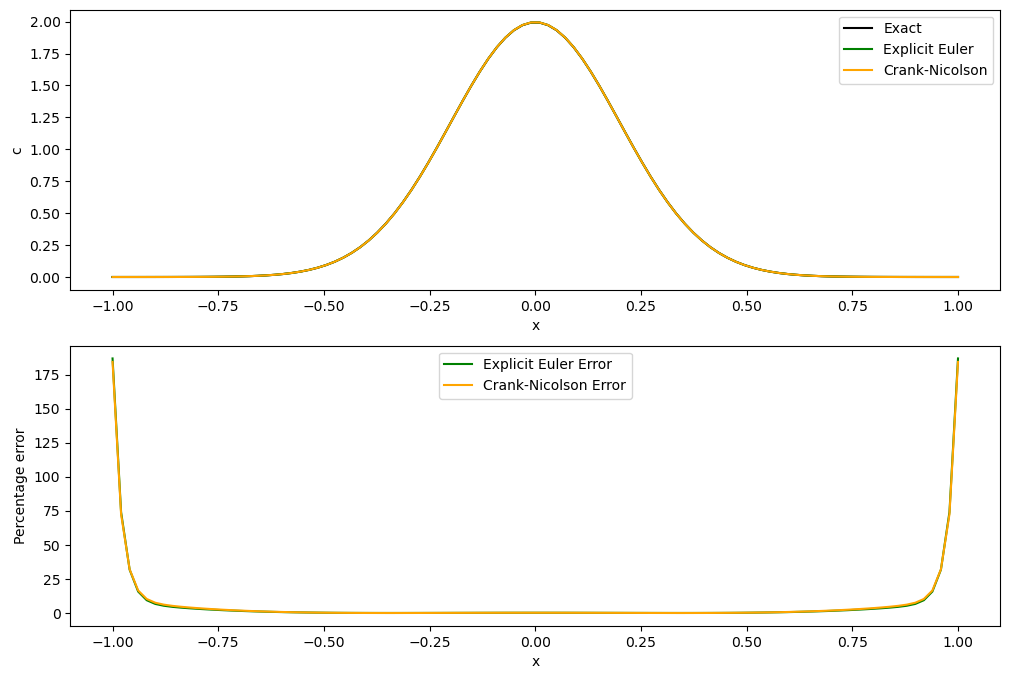

In [9]:
# This is an investigation of the width over which each numerical method accurately represents the exact solution to the diffusion equation


kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x


c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson
c_exact = (1/(4*np.pi*kappa*(t_end+10)))**0.5*np.exp(-x**2/(4*kappa*(t_end+10)))


fig, ax1 = plt.subplots(figsize=(12,8), nrows=2)
ax1=ax1.flatten()

ax1[0].plot(x, c_exact, c='k', label='Exact')
ax1[0].plot(x, c_EE[:,-1], c='green', label='Explicit Euler')
ax1[0].plot(x, c_CN[:,-1], c='orange', label='Crank-Nicolson')
ax1[0].legend()

ax1[0].set_xlabel('x')
ax1[0].set_ylabel('c')

ax1[1].plot(x, (c_EE[:,-1]-c_exact)/c_exact *100, c='green', label='Explicit Euler Error')
ax1[1].plot(x, (c_CN[:,-1]-c_exact)/c_exact *100, c='orange', label='Crank-Nicolson Error')
ax1[1].legend()

ax1[1].set_xlabel('x')
ax1[1].set_ylabel('Percentage error')


plt.show()

**Investigation 1 discussion**

From the plots above it can be seen that around the centre of the diffusion, both the Explicit Euler and Crank-Nicolson numerical models give good approximations to the exact diffusion equation with a low percentage error. At greater distances from the diffusion, the percentage error in the numberical model increases. There is a large error between the exact solution and the numberical models for distances close to the boundary. \\

As the diffusion equation that produces the exact solution is beting modelled as an unbounded 1-D diffusion equation but the numerical solutions impose bondary conditions in the x dimension this large deviation close to the boundary of the numberical models is to be expected. It should be noted however that the absolute error of the numerical models in this region is small compared to the values present in the central region of the graph, and also that the model capture the diffusion profile well at the endtime being investigated.

#### Investigation 2 - Errors due to grid spacing and timestep


Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

The first requirement is to determine what method to measure the over error of the graph is to look at the sum of the squared differences between the numerical model and the exact solution.

As this process cares about the absolute error in the model and not the fractional model, the high percentage error experiences at the boundaries of the numerical models is not an issue as the absolute errors seen about $x=0$ are orders of magnitude greater than those observed at the edges.

In [10]:
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time

# Size of the physical domain
x_start = -1
x_end = 1


In [11]:
# This makes an array of values for both Nt and Nx based upon a log scale
Nt_num = 10
Nx_num = 10

#Nt_values = np.logspace(3, 4, Nt_num, base=10)
#Nx_values = np.logspace(2, 3, Nx_num, base=10)

Nt_values = np.linspace(200, 1000, Nt_num).astype(int)
Nx_values = np.linspace(50, 200, Nx_num).astype(int)


# This makes a mesh of the
Nt_mesh, Nx_mesh = np.meshgrid(Nt_values, Nx_values)


# The exact run for the



# Create an empty 2D array for the EE and CN runs

EE_2d = np.zeros((len(Nt_values), len(Nx_values)))
CN_2d = np.zeros((len(Nt_values), len(Nx_values)))


# This iterates through each value of
for i in range(len(Nx_values)):
    for j in range(len(Nt_values)):
      Nt = Nt_mesh[i,j].astype(int)
      Nx = Nx_mesh[i,j].astype(int)

      t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
      x = np.linspace(x_start, x_end, Nx)

      c_exact = (1/(4*np.pi*kappa*(t_end+10)))**0.5*np.exp(-x**2/(4*kappa*(t_end+10)))
      c_EE = EE(x, t, kappa) # explicit Euler
      c_CN = CN(x, t, kappa) # Crank-Nicolson

      EE_2d[i,j] = np.sum((c_EE[:, -1]-c_exact)**2)
      CN_2d[i,j] = np.sum((c_CN[:, -1]-c_exact)**2)






Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.12 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.08 seconds


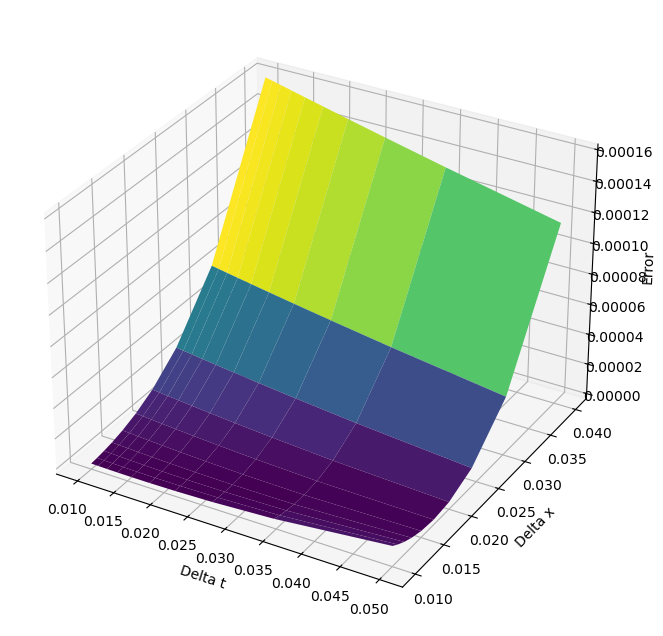

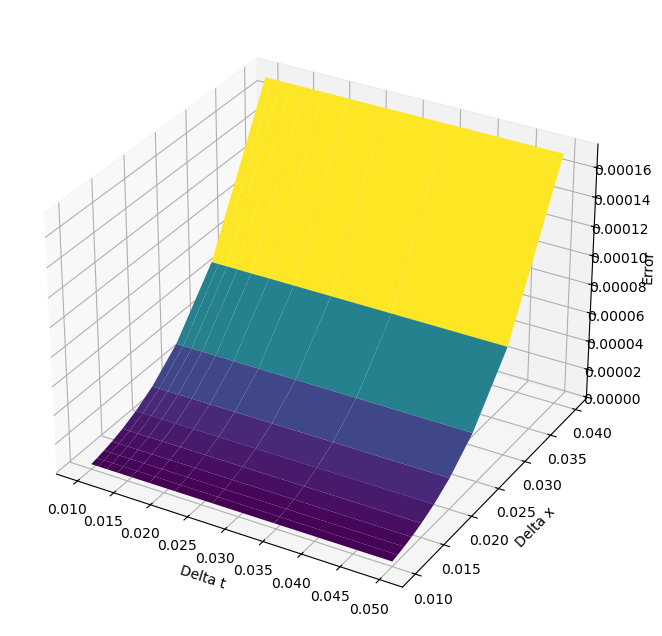

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd


ax = plt.figure(figsize=(12,8)).add_subplot(projection='3d')
ax.plot_surface(10/Nt_mesh, 2/Nx_mesh, EE_2d, cmap='viridis')
ax.set_xlabel('Delta t')
ax.set_ylabel('Delta x')
ax.set_zlabel('Error')
plt.show()

ax1=plt.figure(figsize=(12,8)).add_subplot(projection='3d')
ax1.plot_surface(10/Nt_mesh, 2/Nx_mesh, CN_2d, cmap='viridis')
ax1.set_xlabel('Delta t')
ax1.set_ylabel('Delta x')
ax1.set_zlabel('Error')
plt.show()


#### Investigation 3

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

## 3. Optional further investigations



The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?